In [29]:
# Optional, clears previous session
import tensorflow.keras.backend as K
K.clear_session()

In [1]:
import pymc as pm
print(pm.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
import tensorflow as tf
import seaborn

5.12.0


2025-01-13 20:12:38.313278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import data
path_to_data = '../data/ml-32m/'
print(path_to_data)
ratings = pd.read_csv(os.path.join(path_to_data, 'ratings.csv'))
movies = pd.read_csv(os.path.join(path_to_data, 'movies.csv'))

../data/ml-32m/


In [3]:
# sample 10% randomly, random_state ensures reproducibility
ratings = ratings.sample(frac=0.1, random_state=42)  # 0.1 means 10% of the dataset
movies = movies.sample(frac=0.1, random_state=42)

In [4]:
print(ratings.head(3), '\n')
print(movies.head(3))

          userId  movieId  rating  timestamp
10685861   66954      781     5.0  850944577
1552723     9877      574     4.0  945495614
6145184    38348     1088     2.0  999974867 

       movieId                   title             genres
24103   120510  Value for Money (1955)     Comedy|Romance
65574   212955     Face of Evil (1996)     Drama|Thriller
57105   193912      Spring 1941 (2007)  Drama|Romance|War


In [5]:
print(ratings.describe())

             userId       movieId        rating     timestamp
count  3.200020e+06  3.200020e+06  3.200020e+06  3.200020e+06
mean   1.003224e+05  2.933709e+04  3.540462e+00  1.275296e+09
std    5.792803e+04  5.098177e+04  1.058937e+00  2.560877e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  8.228736e+08
25%    5.016600e+04  1.231000e+03  3.000000e+00  1.051413e+09
50%    1.003430e+05  3.452000e+03  3.500000e+00  1.272794e+09
75%    1.504750e+05  4.419900e+04  4.000000e+00  1.503103e+09
max    2.009480e+05  2.927550e+05  5.000000e+00  1.697164e+09


In [6]:
# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


In [7]:
# Normalise data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ratings['scaled_rating'] = scaler.fit_transform(ratings[['rating']])

Index([0.7777777777777777, 0.5555555555555556,                1.0,
       0.6666666666666665, 0.8888888888888888, 0.3333333333333333,
       0.4444444444444445, 0.1111111111111111, 0.2222222222222222,
                      0.0],
      dtype='float64', name='scaled_rating')


<BarContainer object of 10 artists>

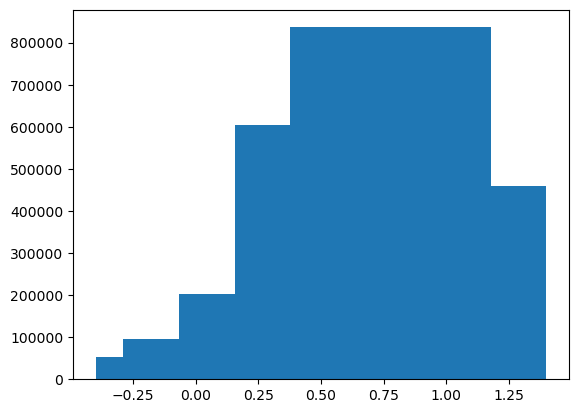

In [8]:
# Plot ratings vs counts histogram to visualise data
rating_counts = ratings['scaled_rating'].value_counts()
print(rating_counts.index)
plt.bar(rating_counts.index, rating_counts.values)

In [9]:
# Merge dataframes to make dataframe containing ratings and genres
full_ratings = pd.merge(ratings, movies, on='movieId')

In [10]:
print("User Preferences Matrix:")
print(full_ratings.head(3), '\n')

User Preferences Matrix:
   userId  movieId  rating   timestamp  scaled_rating                 title  \
0   64197    48516     3.5  1211725237       0.666667  Departed, The (2006)   
1  163220    53887     3.5  1589879484       0.666667   O Lucky Man! (1973)   
2  159849     2722     3.0  1289394589       0.555556  Deep Blue Sea (1999)   

                          genres  
0           Crime|Drama|Thriller  
1   Comedy|Drama|Fantasy|Musical  
2  Action|Horror|Sci-Fi|Thriller   



In [11]:
# OLD CELL BEFORE EXPLODED THE GENRES
# Now group data by userID and genres, assign a mean rating for each (UserID, genre) pair then unpack these into a table
# Unfilled genres are filled with 0 rating

#user_pref = full_ratings.groupby(['userId', 'genres']).rating.mean().unstack(fill_value=0)

In [12]:
# Split the genres and explode the rows
# This is to deal with multiple genre's associated with each movie.
full_ratings['genres'] = full_ratings['genres'].str.split('|')
exploded_ratings = full_ratings.explode('genres')
print(exploded_ratings.head(10), '\n')

   userId  movieId  rating   timestamp  scaled_rating                 title  \
0   64197    48516     3.5  1211725237       0.666667  Departed, The (2006)   
0   64197    48516     3.5  1211725237       0.666667  Departed, The (2006)   
0   64197    48516     3.5  1211725237       0.666667  Departed, The (2006)   
1  163220    53887     3.5  1589879484       0.666667   O Lucky Man! (1973)   
1  163220    53887     3.5  1589879484       0.666667   O Lucky Man! (1973)   
1  163220    53887     3.5  1589879484       0.666667   O Lucky Man! (1973)   
1  163220    53887     3.5  1589879484       0.666667   O Lucky Man! (1973)   
2  159849     2722     3.0  1289394589       0.555556  Deep Blue Sea (1999)   
2  159849     2722     3.0  1289394589       0.555556  Deep Blue Sea (1999)   
2  159849     2722     3.0  1289394589       0.555556  Deep Blue Sea (1999)   

     genres  
0     Crime  
0     Drama  
0  Thriller  
1    Comedy  
1     Drama  
1   Fantasy  
1   Musical  
2    Action  
2   

In [13]:
# Now group data by userID and genres, assign a mean rating for each (UserID, genre) pair then unpack these into a table
# Unfilled genres are filled with 0 rating
user_pref = exploded_ratings.groupby(['userId', 'genres'])['rating'].mean().unstack(fill_value=0)

In [14]:
# Plot heatmap of correlations between different genres: 
user_pref_sample = user_pref.sample(frac=0.5)  # Take 10% of data to reduce computational time
genre_correlation = user_pref_sample.corr() # computes the correlation matrix across columns of user_pref matrix (ie across diff genres)


<Axes: xlabel='genres', ylabel='genres'>

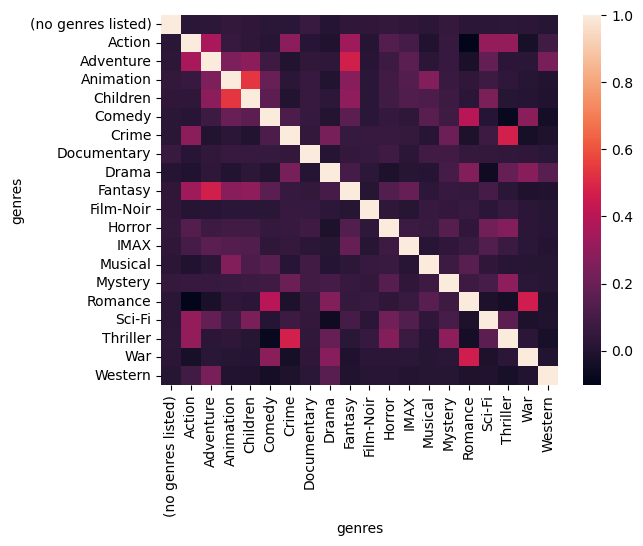

In [15]:
seaborn.heatmap(genre_correlation)

In [16]:
# Now associate a unique integer with every userID and movieID using sklearn's label encoder
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

exploded_ratings['userId'] = user_encoder.fit_transform(exploded_ratings['userId'])
exploded_ratings['movieId'] = movie_encoder.fit_transform(exploded_ratings['movieId'])

In [17]:
# Split the sampled dataframe exploded_ratings into training and testing 
from sklearn.model_selection import train_test_split
training_ratings, testing_ratings = train_test_split(exploded_ratings, test_size=0.2, random_state=10)
print(training_ratings['scaled_rating'].max())

1.0


In [18]:
# We now need to define embeddings for each userID and movieID. This represents every user and movie as a vector. 
# This is helpful as deals better with unseen userID's and movieID's. Similar users and movies will be close vectors in the embedding space after learning.
# Calc no. unique users
num_users = len(user_encoder.classes_) #user_encoder,classes stores the unique sorted different userID's before lebel encoding
num_movies = len(movie_encoder.classes_)

# Define embedding layers
user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=50)  # Embedding size = 50 can be tuned. Too high leads to overfitting.
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=50)


In [25]:
# Input layers
user_input = tf.keras.layers.Input(shape=(1,), name="user_input")
movie_input = tf.keras.layers.Input(shape=(1,), name="movie_input")

# Look up embeddings
user_vec = user_embedding(user_input)
movie_vec = movie_embedding(movie_input)

# Flatten embedding vectors
user_vec = tf.keras.layers.Flatten()(user_vec)
movie_vec = tf.keras.layers.Flatten()(movie_vec)

# Combine embeddings
concat = tf.keras.layers.Concatenate()([user_vec, movie_vec])

# Add dense layers
dense = tf.keras.layers.Dense(128, activation="relu")(concat)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dense)  # Predict rating. Single neuron as predicting a single score for a user/movie pair
# Use sigmoid activation function as ratings are bounded [0,1]

# Build the model
model = tf.keras.models.Model(inputs=[user_input, movie_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [26]:
# Now train the model

# INputs
X_train = [training_ratings['userId'].values, training_ratings['movieId'].values] #thisis the input data to the model
y_train = training_ratings['scaled_rating'].values # Target ratings we're trying to predict. 

# Train
model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.2) # Model uses MSE to evaluate how well it's doing and updates the weights 
# every 64 user/movie pairs passed through the neural network. It sees the data 10 times (10 epochs).


Epoch 1/2
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 339s 43ms/step - loss: 0.0178 - mae: 0.0893 - val_loss: 0.0162 - val_mae: 0.0861
Epoch 2/2
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 408s 52ms/step - loss: 0.0064 - mae: 0.0582 - val_loss: 0.0140 - val_mae: 0.0770


In [27]:
X_test = [testing_ratings['userId'].values, testing_ratings['movieId'].values] # Input user and movie IDs
y_test = testing_ratings['scaled_rating'].values # Correct movie ratings

# Evaluate
model.evaluate(X_test, y_test) # Run the model on the test data. Then compare to the actual rankings

# Predict for new user-movie pairs
predictions = model.predict(X_test) # Array containing the predictions


4909/4909 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0138 - mae: 0.0766
4909/4909 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


/var/folders/s9/8tvqn8yj2qb1sgg4q_ltvnp00000gq/T/ipykernel_10335/2768643844.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


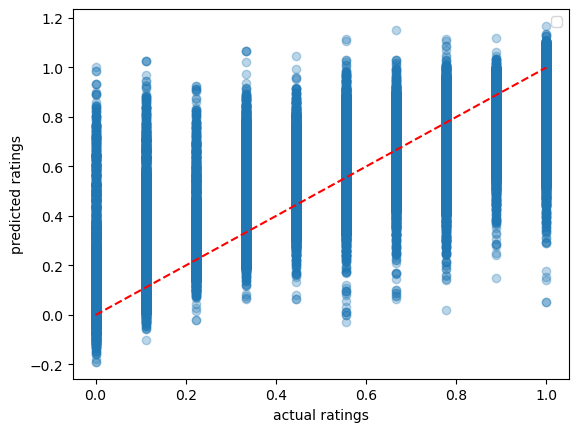

In [28]:
# Now visualise on scatter plot

plt.scatter(y_test, predictions, alpha = 0.3)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('actual ratings')
plt.ylabel('predicted ratings')
plt.legend()

In [23]:
# Now assume uniform prior for genres, use Dirichilet distribution as total prob sums to 1
with pm.Model() as model:
    user_genre_pref = pm.Dirichlet('user_genre_pref', a=np.ones(user_pref.shape[1]))